In [1]:
import sqlite3        #import relevant materials
import numpy as np
import pandas as pd

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [3]:
conn = sqlite3.connect('database-2.sqlite')
c = conn.cursor()

## Our first question: Does being home increase your odds of winning according to bookmakers?


First, We extract the data regarding every single match and the odds of each team across 4 different sports books: Bet 365, Bet&Win, Interwetten, and Ladbrokes.

In [4]:
c.execute('''SELECT season, date, match_api_id, home_team_api_id, away_team_api_id, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA from Match''')

In [5]:
Odds = pd.DataFrame(c.fetchall())

In [6]:
Odds = Odds.rename(columns = {0: 'Season', 1: 'Date', 2: 'Match API', 3: 'Home Team', 4: 'Away Team', 5: 'Bet 365 Home Win Odds', 6: 'Bet 365 Draw Odds',  7: 'Bet 365 Away Win Odds', 8: 'Bet&Win Home Win Odds', 9: 'Bet&Win Draw Odds', 10: 'Bet&Win Away Win Odds', 11: 'Interwetten Home Win Odds', 12: 'Interwetten Draw Odds', 13: 'Interwetten Away Win Odds', 14: 'Ladbrokes Home Win Odds', 15: 'Ladbrokes Draw Odds', 16: 'Ladbrokes Away Win Odds'})






In [7]:
c.execute('''SELECT * FROM Team ''')

In [8]:
Teams = pd.DataFrame(c.fetchall())

In [9]:
Teams = Teams.rename(columns = {1: 'Team ID', 2: 'FIFA Team ID', 3: 'Team Full Name', 4: 'Team Short Name'})

In [10]:
test = []
team_name = []
for x in tqdm(range(len(Teams))):
    test.append(Teams['Team ID'][x])
    team_name.append(Teams['Team Full Name'][x])

In [11]:
for x in tqdm(range(len(test))):
    Odds = Odds.replace(test[x], team_name[x])
    
# With this for loop, we are replacing the Team ID which is provided from the table "Match" and replacing it with
# the actual team name from the table "Team"

In [12]:
Odds = Odds.dropna()

In [13]:
Man_City_Home = Odds.loc[Odds['Home Team'] == 'Manchester City']

Man_City_Away = Odds.loc[Odds['Away Team'] == 'Manchester City'] 

Man_City_frames = [Man_City_Home, Man_City_Away]

Man_City_Games = pd.concat(Man_City_frames)

Man_City_Games_2008_2009 = Man_City_Games.loc[Man_City_Games['Season'] == '2008/2009']

In [14]:
Bet_365_Home_Odds = []
Bet_365_Away_Odds = []
Bet_Win_Home_Odds = []
Bet_Win_Away_Odds = []
Interwetten_Home_Odds = []
Interwetten_Away_Odds = []
Ladbrokes_Home_Odds = []
Ladbrokes_Away_Odds = []
opponent = []
for x in Man_City_Games_2008_2009['Home Team']:
    for y in Man_City_Games_2008_2009['Away Team']:
        if x == 'Manchester City':
            pass
        elif x == y:
            a = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Away Team'] == x]['Bet 365 Home Win Odds'].item(),3)
            Bet_365_Home_Odds.append(a)
            b = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Away Team'] == x]['Bet&Win Home Win Odds'].item(),3)
            Bet_Win_Home_Odds.append(b)
            c = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Away Team'] == x]['Interwetten Home Win Odds'].item(),3)
            Interwetten_Home_Odds.append(c)
            d = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Away Team'] == x]['Ladbrokes Home Win Odds'].item(),3)
            Ladbrokes_Home_Odds.append(d)
            opponent.append(x)
            e = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Home Team'] == y]['Bet 365 Away Win Odds'].item(),3)
            Bet_365_Away_Odds.append(e)
            f = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Home Team'] == y]['Bet&Win Away Win Odds'].item(),3)
            Bet_Win_Away_Odds.append(f)
            g = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Home Team'] == y]['Interwetten Away Win Odds'].item(),3)
            Interwetten_Away_Odds.append(g)
            h = round(Man_City_Games_2008_2009.loc[Man_City_Games_2008_2009['Home Team'] == y]['Ladbrokes Away Win Odds'].item(),3)
            Ladbrokes_Away_Odds.append(h)
            opponent.append(x)
            
            

In [15]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [16]:
ManC_Bet365_Home_Odds = np.array(Bet_365_Home_Odds)
ManC_Bet365_Away_Odds = np.array(Bet_365_Away_Odds)

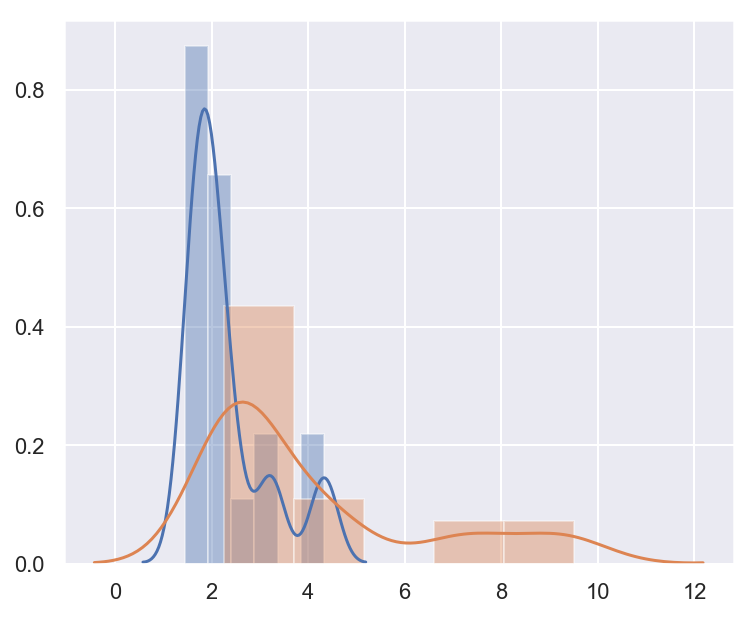

In [17]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(6,5)})
sns.distplot(ManC_Bet365_Home_Odds) # Blue distribution
sns.distplot(ManC_Bet365_Away_Odds) # Orange distribution

As we see above, we placed the distribution of Manchester City Home Odds for Bet 365 during the 2008/2009 Season with the Man City Away Odds for Bet 365 during the same season. Visually, it is easy to see that when Man City was home, they often had a better chance of winning (or lower odds) compared to away games, where you can see the distribution be pushed out even as far as above 9. 

### Our $H_{0}$ for this question is: There is no difference between the odds when Manchester City is Home or Away

### Our $H_{1}$ for this question is: There is a significant difference between the odds when Manchester City is Home or Away

## Calculating the t-statistic
When comparing the difference between groups, we can calculate the two-sample t-statistic like so:

$$\large t = \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{s^{2}_{p} (\frac{1}{n_{1}} + \frac{1}{n_{2}}) }    }  $$

Where $s^{2}_{p}$ is the pooled sample variance, calculated as:

$$\large s^{2}_{p}  = \frac{(n_{1} -1)s^{2}_{1} +  (n_{2} -1)s^{2}_{2}}{n_{1} + n_{2} + 2}  $$

Where $s^{2}_{1}$ and $s^{2}_{2}$ are the variances for each sample given by the formula 
$$ \large s^{2} = \frac{\sum_{i=1}^{n}(x_{i} - \bar{x})^{2}}{n-1} $$


In [18]:
def sample_variance(sample):
    sample_mean = np.mean(sample)
    return np.sum((sample - sample_mean) **2)/ (len(sample) -1)

In [19]:
def pooled_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = sample_variance(sample1), sample_variance(sample2)
    return ((n_1-1) * var_1 + (n_2-1)* var_2)/((n_1 + n_2)-2)

In [20]:
def twosample_tstatistic(expr, ctrl):
    exp_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    pool_var = pooled_variance(expr, ctrl)
    n_e, n_c = len(expr), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(pool_var * ((1/n_e)+(1/n_c)))
    return num / denom

t_stat = twosample_tstatistic(ManC_Bet365_Home_Odds, ManC_Bet365_Away_Odds)
t_stat

-3.0600530354504083

From the functions above, we were able to calculate the t-statics and run a two-sample t-test. A two-sample t-test is used to determine if two population means are equal, which was our null hypothesis.

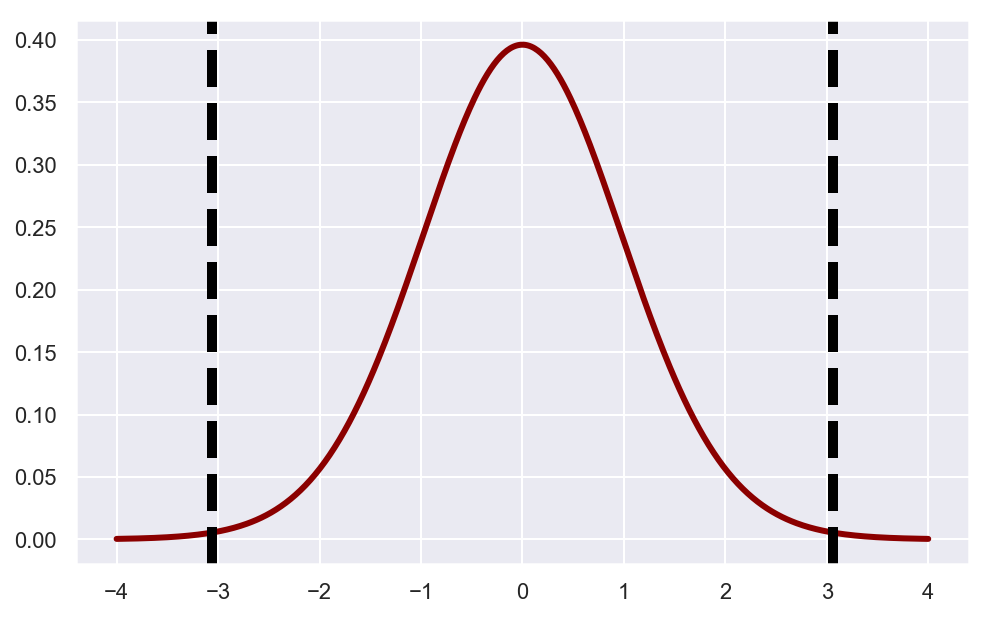

In [21]:
def visualize_t(t_stat, info1, info2):

    
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (info1+info2-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

info1 = len(ManC_Bet365_Home_Odds)
info2 = len(ManC_Bet365_Away_Odds)
visualize_t(t_stat, info1, info2)

The t-distribution above shows a standard distribution with vertical lines identifying the t-stat that signifies our "rejection region". If any of our data was to fall in the region, we would have to our null hypothesis.

We use stats.ttest_ind function to calculate the p-value

In [22]:
stats.ttest_ind(ManC_Bet365_Home_Odds, ManC_Bet365_Away_Odds)

Ttest_indResult(statistic=-3.0600530354504083, pvalue=0.004164693434394226)

### With a p-value < .05, we can reject our null hypothesis and accept that there is a significant difference between Manchester City's odds when they are playing home versus when they are playing away.

 # Our next question: Does a higher defensive aggression result in a higher winning percentage?

#### They say that defense wins championships...now we actually get to prove it!

From our data set, we took the team FIFA statistics for the season in question and compared it to the team's winning percentage in that year. Clearly, we must operate under the assumption that FIFA does an accurate job at predicting/assessing each team's defense

In [41]:
import sqlite3
import numpy as np
conn = sqlite3.connect('database-2.sqlite')
c = conn.cursor()

In [42]:
c.execute('''SELECT team_api_id, date, defencePressure, defencePressureClass, defenceAggression, defenceAggressionClass, defenceTeamWidth, defenceTeamWidthClass, defenceDefenderLineClass, buildUpPlaySpeed, buildUpPlayPassing,chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting from Team_Attributes''')


In [43]:
Attributes = pd.DataFrame(c.fetchall())

Attributes = Attributes.rename(columns = {0: 'Team ID', 1: 'Date', 2: 'Defense Pressure', 3: 'Defense Pressure Class', 4: 'Defense Aggression', 5: 'Defense Aggression Class', 6: 'Defense Team Width', 7: 'Defense Team Width Class', 8: 'Defense Defender Class', 9: 'Build Up Speed', 10: 'Build Up Passing', 11: 'Chance Creation Passing', 12: 'Chance Creation Crossing', 13: 'Chance Creation Shooting'})


In [44]:
for x in range(len(test)):
    Attributes = Attributes.replace(test[x], team_name[x])

In [45]:
Attributes.head()

,Team ID,Date,Defense Pressure,Defense Pressure Class,Defense Aggression,Defense Aggression Class,Defense Team Width,Defense Team Width Class,Defense Defender Class,Build Up Speed,Build Up Passing,Chance Creation Passing,Chance Creation Crossing,Chance Creation Shooting
0,FC Aarau,2010-02-22 00:00:00,50,Medium,55,Press,45,Normal,Cover,60,50,60,65,55
1,FC Aarau,2014-09-19 00:00:00,47,Medium,44,Press,54,Normal,Cover,52,56,54,63,64
2,FC Aarau,2015-09-10 00:00:00,47,Medium,44,Press,54,Normal,Cover,47,54,54,63,64
3,Aberdeen,2010-02-22 00:00:00,60,Medium,70,Double,70,Wide,Cover,70,70,70,70,70
4,Aberdeen,2011-02-22 00:00:00,47,Medium,47,Press,52,Normal,Cover,47,52,53,48,52


### From the information above, I first took all the Attributes from the FIFA game. I have matched them to each team name with each year and their different statistics for that year.

### Now, we are going to compile the winning percentage for each team.

In [46]:
c.execute('''SELECT season, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal from Match''')

Scores = pd.DataFrame(c.fetchall())

Scores = Scores.rename(columns = {0: 'Season', 1: 'Date', 2: 'Match API', 3: 'Home Team', 4: 'Away Team', 5: 'Home Team Goal', 6: 'Away Team Goal'})

for x in range(len(test)):
    Scores = Scores.replace(test[x], team_name[x])

Scores['Winning Team'] = ''

Scores['Losing Team'] = ''


In [47]:
for x in tqdm(range(len(Scores['Season']))):
    if Scores['Home Team Goal'][x] > Scores['Away Team Goal'][x]:
        Scores.loc[x,'Winning Team'] = Scores.loc[x,'Home Team']
    elif Scores['Home Team Goal'][x] < Scores.loc[x, 'Away Team Goal']:
        Scores.loc[x,'Winning Team'] = Scores.loc[x, 'Away Team']
    else:
        Scores.loc[x,'Winning Team'] = 'Draw'

In [48]:
for x in tqdm(range(len(Scores['Season']))):
    if Scores['Home Team Goal'][x] > Scores['Away Team Goal'][x]:
        Scores.loc[x,'Losing Team'] = Scores.loc[x,'Away Team']
    elif Scores['Home Team Goal'][x] < Scores.loc[x, 'Away Team Goal']:
        Scores.loc[x,'Losing Team'] = Scores.loc[x, 'Home Team']
    else:
        Scores.loc[x,'Losing Team'] = 'Draw'
   

KeyboardInterrupt: 

In [ ]:
Attributes['Year'] = ''

for x in tqdm(range(len(Attributes))):
    Attributes['Year'][x] = Attributes['Date'][x][:4]

In [ ]:
Season_2010_2011 = Scores.loc[Scores['Season'] == '2010/2011']

d = Season_2010_2011.groupby('Winning Team').size()

d = d.to_dict()

d.pop('Draw')

In [ ]:
Wins_2010 = [v for v in d.values()]

WTeams_2010 = [x for x in d.keys()]

Season_2010 = pd.DataFrame(WTeams_2010)

Season_2010['Wins'] = Wins_2010

Season_2010 = Season_2010.rename(columns={0:'Team'})

In [ ]:
e = Season_2010_2011.groupby('Losing Team').size()

e = e.to_dict()

e.pop('Draw')

Losses_2010 = [v for v in e.values()]

LTeams_2010 = [x for x in e.keys()]

In [ ]:
len(Wins_2010), len(Losses_2010)

###### WHAT?! There are more results in wins than losses? How could this be possible?!

...unfortunately for us, an "undefeated team" lies amongst us. This means we are going to have to do some digging and find who that undefeated team is, add them to the losses list with a 0, find that missing team, then adjust accordingly.

In [ ]:
LTeams_2010.append(0)

In [ ]:
TEST = pd.DataFrame(data = WTeams_2010)
TEST[1] = LTeams_2010

Let's start digging...

In [ ]:
TEST[0:50]

Not in the first 50...let's check the next 50...

In [ ]:
TEST[50:100]

## BANG!

FC Porto had an undefeated season in 2010. So we have to add them to the Losers list and add a value of 0 for them at the end, and then we can continue...

In [ ]:
LTeams_2010.remove(0)
LTeams_2010.append('FC Porto')
Losses_2010.append(0)


In [ ]:
Final_2010_Losses = pd.DataFrame({'Team': LTeams_2010, 'Team Loss': Losses_2010})

In [ ]:
Final_2010_Losses = Final_2010_Losses.sort_values('Team')

In [ ]:
Final_2010_Losses = Final_2010_Losses.reset_index()
Final_2010_Losses = Final_2010_Losses.drop(['index'], axis=1)

Season_2010['Loss'] = Final_2010_Losses['Team Loss']

In [ ]:
Season_2010.head()

Perfect! Now we continue to account for all draws in 2010 Season...

In [ ]:
Season_2010_2011 = Season_2010_2011.reset_index()

Season_2010_2011 = Season_2010_2011.drop(['index'], axis=1)

Draws_2010 = []
for x in range(len(Season_2010_2011['Season'])):
    if Season_2010_2011.loc[x, 'Winning Team'] == 'Draw':
        Draws_2010.append(Season_2010_2011.loc[x, 'Home Team'])
        Draws_2010.append(Season_2010_2011.loc[x, 'Away Team'])

        
# This for loop adds each time a team draws to a list, then we use "Counter" to count how many times each team is listed
# and add them to a dictionary!

from collections import Counter        
draws = Counter(Draws_2010)

draws_2010 = {}
for key, value in draws.items():
    draws_2010[key] = value
    
Season_2010['Draws'] = ''

In [ ]:
Final_2010_Draws = pd.DataFrame(draws_2010.items())

Final_2010_Draws  = Final_2010_Draws .sort_values(0)

Final_2010_Draws  = Final_2010_Draws .reset_index()

Final_2010_Draws  = Final_2010_Draws .drop(['index'], axis=1)

Season_2010['Draws'] = Final_2010_Draws [1]

Season_2010 = Season_2010.reset_index()

Season_2010 = Season_2010.drop(['index'], axis=1)

In [ ]:
Season_2010.head()

Perfect! Now let's create a function that will automatically add winning percentage to our table!

In [ ]:
def winning_percent(season):
    season['Winning %'] = 100*((season['Wins']+(season['Draws']/2))/(season['Wins']+(season['Draws']+(season['Loss']))))


In [ ]:
pd.set_option('precision', 2) # Limits our percentage to just two decimal places

winning_percent(Season_2010)

In [ ]:
Season_2010.head()

Excellent! Now that we have the winning % calculated, we have to merge the table with the team's statistics with the table we just made.

In [ ]:
Defense_2010 = Attributes.loc[Attributes['Year']=='2010']

Defense_2010 = Defense_2010.sort_values('Team ID')

Defense_2010 = Defense_2010.reset_index()

Defense_2010 = Defense_2010.drop(['index'], axis=1)

Defense_2010 = Defense_2010.drop(Defense_2010.index[156]) #To save the trouble of showing the problem, this data set double counted a team, so we deleted them with this code

Defense_2010 = Defense_2010.reset_index()

Defense_2010 = Defense_2010.drop(['index'], axis=1)

In [ ]:
Season_2010['Defense Pressure'] = 0    # With this code, we are adding columns to our Winning % table that we will fill in with info from the Attributes table
Season_2010['Defense Aggression'] = 0
Season_2010['Defense Team Width'] = 0
Season_2010['Build Up Speed'] = 0
Season_2010['Build Up Passing'] = 0
Season_2010['Chance Creation Passing'] = 0
Season_2010['Chance Creation Crossing'] = 0
Season_2010['Chance Creation Shooting'] = 0

Season_2010 = Season_2010.reset_index()
Season_2010 = Season_2010.drop(['index'], axis=1)

In [ ]:
def defense_type(year, season):       # This function will automatically run any Attributes table created with any winning% table create to give a final table with all the info!
    for team in tqdm(season['Team']):
        for x in year['Team ID']:
            if team == x:
                season.loc[season['Team'] == team, 'Defense Pressure'] = year.loc[year['Team ID'] == x, 'Defense Pressure'].item()
                season.loc[season['Team'] == team, 'Defense Aggression'] = year.loc[year['Team ID'] == x, 'Defense Aggression'].item()
                season.loc[season['Team'] == team, 'Defense Team Width'] = year.loc[year['Team ID'] == x, 'Defense Team Width'].item()
                season.loc[season['Team'] == team, 'Build Up Speed'] = year.loc[year['Team ID'] == x, 'Build Up Speed'].item()
                season.loc[season['Team'] == team, 'Build Up Passing'] = year.loc[year['Team ID'] == x, 'Build Up Passing'].item()
                season.loc[season['Team'] == team, 'Chance Creation Passing'] = year.loc[year['Team ID'] == x, 'Chance Creation Passing'].item()
                season.loc[season['Team'] == team, 'Chance Creation Crossing'] = year.loc[year['Team ID'] == x, 'Chance Creation Crossing'].item()
                season.loc[season['Team'] == team, 'Chance Creation Shooting'] = year.loc[year['Team ID'] == x, 'Chance Creation Shooting'].item()
            else:
                pass
    return season

In [ ]:
defense_type(Defense_2010, Season_2010)

## Fantastic!

Now, let's check the correlation table and Pearson value to see if our hypothesis of high defense aggression means high winning %, or, in official terms: 

### Our $H_{0}$ for this question is: There is no relatinship between defense aggression and winning %

### Our $H_{1}$ for this question is: There is a correlation between defense aggression and winning %

In [ ]:
Season_2010.corr()

In [ ]:
import scipy

scipy.stats.pearsonr(Season_2010['Winning %'], Season_2010['Defense Aggression'])

### Heartbreaking...

As noted above, our correlation is low, and our p-value is even higher, showing that we cannot reject our null hypothesis. The scatterplot below demonstrates more clearly how poor this hypothesis was.

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Season_2010['Winning %'], Season_2010['Defense Pressure']);
plt.xlabel('Winning%')
plt.ylabel('Defense Pressure')

# Question #3: If defense doesn't win championships, does offense?

Since the one metric for defense didn't work, we will try all 3 for offense. 

In [ ]:
scipy.stats.pearsonr(Season_2010['Winning %'], Season_2010['Chance Creation Passing'])

In [ ]:
scipy.stats.pearsonr(Season_2010['Winning %'], Season_2010['Chance Creation Crossing'])

In [ ]:
scipy.stats.pearsonr(Season_2010['Winning %'], Season_2010['Chance Creation Shooting'])

In [ ]:
#Question #4: Do home games make a difference on the home teams chance of winning?

In [363]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import distplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import math
import statistics 
import scipy
import scipy.stats as stats
from scipy.stats.distributions import norm
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon,kurtosis,skew
from statistics import stdev,mean
import sqlite3

#Getting what we need to Start


In [364]:
conn = sqlite3.connect('database-2.sqlite')
c = conn.cursor()
a = conn.cursor()
b = conn.cursor()
d = conn.cursor()
e = conn.cursor()
f = conn.cursor()


In [365]:
c.execute("""select home_team_goal, away_team_goal,away_team_api_id,
match_api_id, Match.date, Team.team_long_name,count(home_team_api_id) as HomeWins FROM Match 
JOIN Team ON home_team_api_id= Team.team_api_id
WHERE home_team_goal > away_team_goal
group by home_team_api_id
ORDER BY team_long_name;""")
#SQL for HOMEWINS

In [366]:
HomeWinsdf=pd.DataFrame(c.fetchall())
HomeWinsdf.columns=['home_team_goal','away_team_goal','away_team_api_id','match_api_id','Match.date','team_long_name','Home_Wins']
HomeWinsdf.head()
#Homewins dataframe

,home_team_goal,away_team_goal,away_team_api_id,match_api_id,Match.date,team_long_name,Home_Wins
0,3,0,9788,856962,2010-10-30 00:00:00,1. FC Kaiserslautern,8
1,2,1,9904,499422,2008-11-07 00:00:00,1. FC Köln,32
2,3,2,8178,674495,2010-03-07 00:00:00,1. FC Nürnberg,30
3,3,0,8358,674353,2009-10-24 00:00:00,1. FSV Mainz 05,55
4,1,0,9851,1019691,2011-12-18 00:00:00,AC Ajaccio,16


In [367]:
HomeWinsdf.loc[HomeWinsdf['team_long_name']=='Widzew Łódź']

,home_team_goal,away_team_goal,away_team_api_id,match_api_id,Match.date,team_long_name,Home_Wins
287,4,1,1957,838488,2010-10-23 00:00:00,Widzew Łódź,23
288,2,1,8030,506653,2008-12-05 00:00:00,Widzew Łódź,7


In [368]:
f.execute("""select home_team_goal, away_team_goal,match_api_id, date, Team.team_long_name, 
count(home_team_api_id) as HomeDraws FROM Match 
JOIN Team ON home_team_api_id= Team.team_api_id
WHERE away_team_goal = home_team_goal
GROUP BY home_team_api_id
ORDER BY team_long_name;""")
#SQL HOMETEAM Draws


In [369]:
HomeDrawsdf=pd.DataFrame(f.fetchall())
HomeDrawsdf.columns = ('home_team_goal','away_team_goal','match_api_id','date','team_long_name','HomeDraws')
HomeDrawsdf.head()
#Homedraws dataframe with teams

,home_team_goal,away_team_goal,match_api_id,date,team_long_name,HomeDraws
0,3,3,856989,2010-11-13 00:00:00,1. FC Kaiserslautern,11
1,1,1,499475,2009-01-31 00:00:00,1. FC Köln,31
2,2,2,674364,2009-10-31 00:00:00,1. FC Nürnberg,21
3,2,2,674270,2009-08-08 00:00:00,1. FSV Mainz 05,29
4,2,2,1019589,2011-11-19 00:00:00,AC Ajaccio,19


In [370]:
d.execute("""select match_api_id, home_team_goal,
Team.team_long_name, home_team_api_id, count(Team.team_api_id) as NumOfHomeGames
from Match
JOIN Team ON home_team_api_id= Team.team_api_id
group by home_team_api_id
order by team_long_name;""")
#SQL # of games

In [371]:
NumberOfHomeGamesdf=pd.DataFrame(d.fetchall())
NumberOfHomeGamesdf.columns=('match_api_id','home_team_goal','team_long_name','home_team_api_id','NumOfHomeGames')
NumberOfHomeGamesdf.head()
# of games Dataframe

,match_api_id,home_team_goal,team_long_name,home_team_api_id,NumOfHomeGames
0,856962,3,1. FC Kaiserslautern,8350,34
1,499404,0,1. FC Köln,8722,102
2,674268,1,1. FC Nürnberg,8165,85
3,674270,2,1. FSV Mainz 05,9905,119
4,1019336,0,AC Ajaccio,8576,57


In [372]:
HomeGame_Data = pd.merge(HomeDrawsdf,HomeWinsdf,on='team_long_name')
HomeGame_Data2 = pd.merge(HomeGame_Data,NumberOfHomeGamesdf,on='team_long_name')
HomeGame_Data2real= HomeGame_Data2[['team_long_name','HomeDraws','Home_Wins','NumOfHomeGames']]
HomeGame_Data2real
#Putting new Dataframe merging Home game wins, draws, number of games, with team names. 

,team_long_name,HomeDraws,Home_Wins,NumOfHomeGames
0,1. FC Kaiserslautern,11,8,34
1,1. FC Köln,31,32,102
2,1. FC Nürnberg,21,30,85
3,1. FSV Mainz 05,29,55,119
4,AC Ajaccio,19,16,57
5,AC Arles-Avignon,6,2,19
6,AC Bellinzona,13,17,54
7,ADO Den Haag,39,50,136
8,AJ Auxerre,27,31,76
9,AS Monaco,39,53,114


In [373]:
a.execute("""select home_team_goal, away_team_goal,match_api_id,home_team_api_id, date, 
Team.team_long_name,Team.team_api_id, count(away_team_api_id) as AwayWins
FROM Match 
JOIN Team ON away_team_api_id= Team.team_api_id
WHERE away_team_goal > home_team_goal
GROUP BY away_team_api_id
ORDER BY team_long_name;""")
#SQL for AWAYWINS

In [374]:
Awaywinsdf=pd.DataFrame(a.fetchall())
Awaywinsdf.columns=['home_team_goal','away_team_goal','match_api_id','home_team_api_id','date','team_long_name','Team.team_api_id','Away_Wins']
AW= Awaywinsdf[['Team.team_api_id','team_long_name','Away_Wins']]
Awaywinsdf.head()
#Away wins Dataframe

,home_team_goal,away_team_goal,match_api_id,home_team_api_id,date,team_long_name,Team.team_api_id,Away_Wins
0,1,3,856877,8722,2010-08-21 00:00:00,1. FC Kaiserslautern,8350,9
1,1,3,499410,10269,2008-11-01 00:00:00,1. FC Köln,8722,28
2,2,3,674379,8721,2009-11-21 00:00:00,1. FC Nürnberg,8165,19
3,0,1,674496,8226,2010-03-07 00:00:00,1. FSV Mainz 05,9905,33
4,0,2,1019748,9874,2011-12-21 00:00:00,AC Ajaccio,8576,6


In [375]:
b.execute("""select home_team_goal, away_team_goal,match_api_id, date, Team.team_long_name, 
count(away_team_api_id) as AwayDraws FROM Match 
JOIN Team ON away_team_api_id= Team.team_api_id
WHERE away_team_goal = home_team_goal
GROUP BY away_team_api_id
ORDER BY team_long_name;""")
#SQL for Away game Draws

In [376]:
AwayDrawsdf=pd.DataFrame(b.fetchall())
AwayDrawsdf.columns=('home_team_goal','away_team_goal','match_api_id','date','team_long_name','AwayDraws')
AD= AwayDrawsdf[['team_long_name','AwayDraws']]
AwayDrawsdf.head()
#Away games draws dataframe for each team

,home_team_goal,away_team_goal,match_api_id,date,team_long_name,AwayDraws
0,0,0,857248,2011-03-05 00:00:00,1. FC Kaiserslautern,7
1,2,2,499483,2009-02-07 00:00:00,1. FC Köln,23
2,1,1,674277,2009-08-15 00:00:00,1. FC Nürnberg,22
3,3,3,674360,2009-10-31 00:00:00,1. FSV Mainz 05,36
4,2,2,1019674,2011-12-10 00:00:00,AC Ajaccio,21


In [377]:
e.execute("""select match_api_id, away_team_goal,
Team.team_long_name, away_team_api_id, count(Team.team_api_id) as NumOfAwayGames
from Match
JOIN Team ON away_team_api_id= Team.team_api_id
group by away_team_api_id
order by team_long_name;""")
#SQL for # of AwayGames 

In [378]:
NumberOfAwayGamesdf=pd.DataFrame(e.fetchall())
NumberOfAwayGamesdf.columns=('match_api_id','away_team_goal','team_long_name','away_team_api_id','NumOfAwayGames')
NumberOfAwayGamesdf.head()
# of Away games Dataframe

,match_api_id,away_team_goal,team_long_name,away_team_api_id,NumOfAwayGames
0,856877,3,1. FC Kaiserslautern,8350,34
1,499320,1,1. FC Köln,8722,102
2,674355,0,1. FC Nürnberg,8165,85
3,674360,3,1. FSV Mainz 05,9905,119
4,1019530,0,AC Ajaccio,8576,57


In [379]:
NumAG = NumberOfAwayGamesdf[['away_team_api_id','team_long_name','NumOfAwayGames']]
NumAG
#just taking away match_api_id since its grouped by teams not games anymore

,away_team_api_id,team_long_name,NumOfAwayGames
0,8350,1. FC Kaiserslautern,34
1,8722,1. FC Köln,102
2,8165,1. FC Nürnberg,85
3,9905,1. FSV Mainz 05,119
4,8576,AC Ajaccio,57
5,108893,AC Arles-Avignon,19
6,6493,AC Bellinzona,54
7,10217,ADO Den Haag,136
8,8583,AJ Auxerre,76
9,9829,AS Monaco,114


In [380]:
AwayGame_Data = pd.merge(AD,AW, on='team_long_name')
AwayGame_Data

,team_long_name,AwayDraws,Team.team_api_id,Away_Wins
0,1. FC Kaiserslautern,7,8350,9
1,1. FC Köln,23,8722,28
2,1. FC Nürnberg,22,8165,19
3,1. FSV Mainz 05,36,9905,33
4,AC Ajaccio,21,8576,6
5,AC Arles-Avignon,5,108893,1
6,AC Bellinzona,12,6493,8
7,ADO Den Haag,35,10217,29
8,AJ Auxerre,23,8583,22
9,AS Monaco,36,9829,42


In [381]:
AwayGame_Data = pd.merge(AD,AW, on='team_long_name')
AwayGame_Data2 = pd.merge(AwayGame_Data,NumAG,on='team_long_name')
AwayGame_Data2real = AwayGame_Data2[['team_long_name','AwayDraws','Team.team_api_id','Away_Wins','NumOfAwayGames']]
AwayGame_Data2real
#Merging new Dataframe for Away wins, draws, number of games, for each team. 

,team_long_name,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames
0,1. FC Kaiserslautern,7,8350,9,34
1,1. FC Köln,23,8722,28,102
2,1. FC Nürnberg,22,8165,19,85
3,1. FSV Mainz 05,36,9905,33,119
4,AC Ajaccio,21,8576,6,57
5,AC Arles-Avignon,5,108893,1,19
6,AC Bellinzona,12,6493,8,54
7,ADO Den Haag,35,10217,29,136
8,AJ Auxerre,23,8583,22,76
9,AS Monaco,36,9829,42,114


In [382]:
CombinedHomeandAway= pd.merge(HomeGame_Data2real,AwayGame_Data2real,on='team_long_name')
CombinedHomeandAway
#Final Big merge for Stats for both Away and Home Games for each teams entire recorded results for years 2008-2016

,team_long_name,HomeDraws,Home_Wins,NumOfHomeGames,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames
0,1. FC Kaiserslautern,11,8,34,7,8350,9,34
1,1. FC Köln,31,32,102,23,8722,28,102
2,1. FC Nürnberg,21,30,85,22,8165,19,85
3,1. FSV Mainz 05,29,55,119,36,9905,33,119
4,AC Ajaccio,19,16,57,21,8576,6,57
5,AC Arles-Avignon,6,2,19,5,108893,1,19
6,AC Bellinzona,13,17,54,12,6493,8,54
7,ADO Den Haag,39,50,136,35,10217,29,136
8,AJ Auxerre,27,31,76,23,8583,22,76
9,AS Monaco,39,53,114,36,9829,42,114


In [383]:
CombinedHomeandAway.loc[CombinedHomeandAway['Team.team_api_id']==8024]


,team_long_name,HomeDraws,Home_Wins,NumOfHomeGames,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames
410,Widzew Łódź,22,23,60,16,8024,10,60
411,Widzew Łódź,22,23,60,16,8024,10,30
414,Widzew Łódź,22,23,60,5,8024,10,60
415,Widzew Łódź,22,23,60,5,8024,10,30
418,Widzew Łódź,22,23,30,16,8024,10,60
419,Widzew Łódź,22,23,30,16,8024,10,30
422,Widzew Łódź,22,23,30,5,8024,10,60
423,Widzew Łódź,22,23,30,5,8024,10,30
426,Widzew Łódź,22,7,60,16,8024,10,60
427,Widzew Łódź,22,7,60,16,8024,10,30


In [385]:
np.arange(411,472)

array([411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423,
       424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449,
       450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471])

In [387]:
CombinedHomeandAway.drop(np.arange(411,472), axis = 0, inplace=True)
CombinedHomeandAway

,team_long_name,HomeDraws,Home_Wins,NumOfHomeGames,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames
0,1. FC Kaiserslautern,11,8,34,7,8350,9,34
1,1. FC Köln,31,32,102,23,8722,28,102
2,1. FC Nürnberg,21,30,85,22,8165,19,85
3,1. FSV Mainz 05,29,55,119,36,9905,33,119
4,AC Ajaccio,19,16,57,21,8576,6,57
5,AC Arles-Avignon,6,2,19,5,108893,1,19
6,AC Bellinzona,13,17,54,12,6493,8,54
7,ADO Den Haag,39,50,136,35,10217,29,136
8,AJ Auxerre,27,31,76,23,8583,22,76
9,AS Monaco,39,53,114,36,9829,42,114


In [340]:
CombinedHomeandAway[CombinedHomeandAway['team_long_name']=='Arsenal']

,team_long_name,HomeDraws,Home_Wins,NumOfHomeGames,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames
19,Arsenal,34,97,152,39,9825,73,152


In [341]:
CombinedHomeandAway['%HomeWinSuccess']=CombinedHomeandAway.apply(lambda row: row.Home_Wins/row.NumOfHomeGames, axis=1)
CombinedHomeandAway['%AwayWinSuccess']=CombinedHomeandAway.apply(lambda row: row.Away_Wins/row.NumOfAwayGames, axis=1)
CombinedHomeandAway['%HomeDraws']=CombinedHomeandAway.apply(lambda row: row.HomeDraws/row.NumOfHomeGames, axis=1)
CombinedHomeandAway['%AwayDraws']=CombinedHomeandAway.apply(lambda row: row.AwayDraws/row.NumOfAwayGames, axis=1)
CombinedHomeandAway['Difference_of_Wins'] = CombinedHomeandAway['Home_Wins'] - CombinedHomeandAway['Away_Wins']
CombinedHomeandAway
#Created some new columns to Examine more. 

,team_long_name,HomeDraws,Home_Wins,NumOfHomeGames,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames,%HomeWinSuccess,%AwayWinSuccess,%HomeDraws,%AwayDraws,Difference_of_Wins
0,1. FC Kaiserslautern,11,8,34,7,8350,9,34,0.235294,0.264706,0.323529,0.205882,-1
1,1. FC Köln,31,32,102,23,8722,28,102,0.313725,0.274510,0.303922,0.225490,4
2,1. FC Nürnberg,21,30,85,22,8165,19,85,0.352941,0.223529,0.247059,0.258824,11
3,1. FSV Mainz 05,29,55,119,36,9905,33,119,0.462185,0.277311,0.243697,0.302521,22
4,AC Ajaccio,19,16,57,21,8576,6,57,0.280702,0.105263,0.333333,0.368421,10
5,AC Arles-Avignon,6,2,19,5,108893,1,19,0.105263,0.052632,0.315789,0.263158,1
6,AC Bellinzona,13,17,54,12,6493,8,54,0.314815,0.148148,0.240741,0.222222,9
7,ADO Den Haag,39,50,136,35,10217,29,136,0.367647,0.213235,0.286765,0.257353,21
8,AJ Auxerre,27,31,76,23,8583,22,76,0.407895,0.289474,0.355263,0.302632,9
9,AS Monaco,39,53,114,36,9829,42,114,0.464912,0.368421,0.342105,0.315789,11


In [342]:
CombinedHomeandAway[CombinedHomeandAway['team_long_name']=='Arsenal']

,team_long_name,HomeDraws,Home_Wins,NumOfHomeGames,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames,%HomeWinSuccess,%AwayWinSuccess,%HomeDraws,%AwayDraws,Difference_of_Wins
19,Arsenal,34,97,152,39,9825,73,152,0.638158,0.480263,0.223684,0.256579,24


In [344]:
CombinedHomeandAway.describe() 
#Means for Home and Away are out of the number teams.

,HomeDraws,Home_Wins,NumOfHomeGames,AwayDraws,Team.team_api_id,Away_Wins,NumOfAwayGames,%HomeWinSuccess,%AwayWinSuccess,%HomeDraws,%AwayDraws,Difference_of_Wins
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.00000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,19.333333,31.910417,72.333333,18.381250,28064.993750,19.16250,72.333333,0.416809,0.236489,0.288607,0.263602,12.747917
std,12.354427,27.471798,45.998018,12.759967,68017.857319,19.18873,46.007639,0.190370,0.124612,0.143604,0.116222,12.150973
min,1.000000,1.000000,15.000000,1.000000,1601.000000,1.00000,15.000000,0.052632,0.052632,0.052632,0.058824,-6.000000
25%,8.000000,9.000000,30.000000,7.000000,8031.000000,5.00000,30.000000,0.300000,0.155556,0.210526,0.205399,4.000000
50%,17.500000,23.000000,60.000000,16.000000,8559.500000,10.00000,60.000000,0.387993,0.210526,0.264929,0.252982,11.000000
75%,31.000000,45.000000,110.000000,30.000000,9978.000000,26.00000,109.500000,0.517357,0.294118,0.315789,0.294118,21.000000
max,54.000000,131.000000,152.000000,57.000000,274581.000000,103.00000,153.000000,1.000000,0.684211,0.733333,0.666667,51.000000


In [345]:
PopHomeWinsMean= sum(CombinedHomeandAway['Home_Wins'])/sum(CombinedHomeandAway['NumOfHomeGames'])
PopHomeWinsMean 
#Looking at total odds of winning at home games, using every teams success rate.

0.4411578341013825

In [346]:
PopAwayWinsMean= sum(CombinedHomeandAway['Away_Wins'])/sum(CombinedHomeandAway['NumOfAwayGames'])
PopAwayWinsMean 
#Looking at total odds of winning at away games, using every teams success rate.

0.26491935483870965

Text(0, 0.5, 'Frequency')

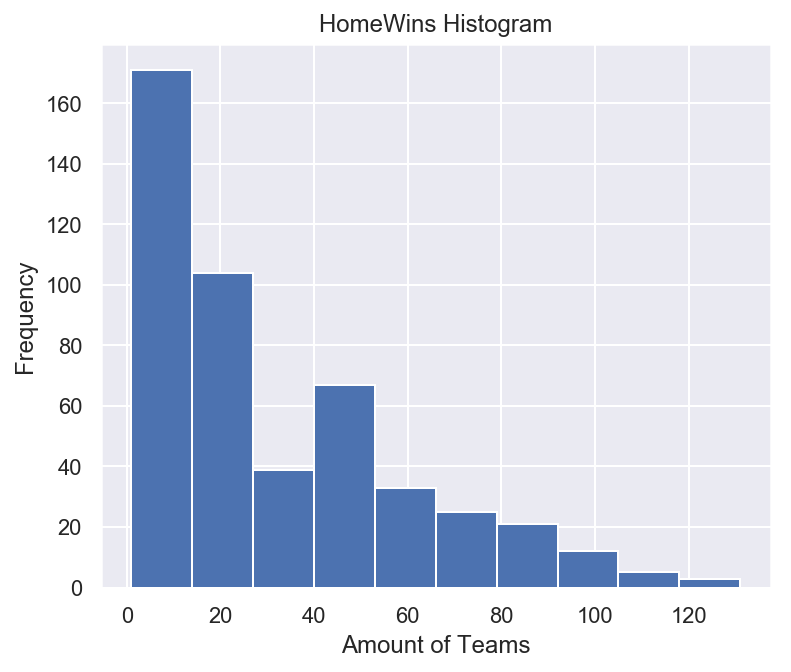

In [347]:
plt.hist(CombinedHomeandAway['Home_Wins']) 
plt.title("HomeWins Histogram")
plt.xlabel("Amount of Teams")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

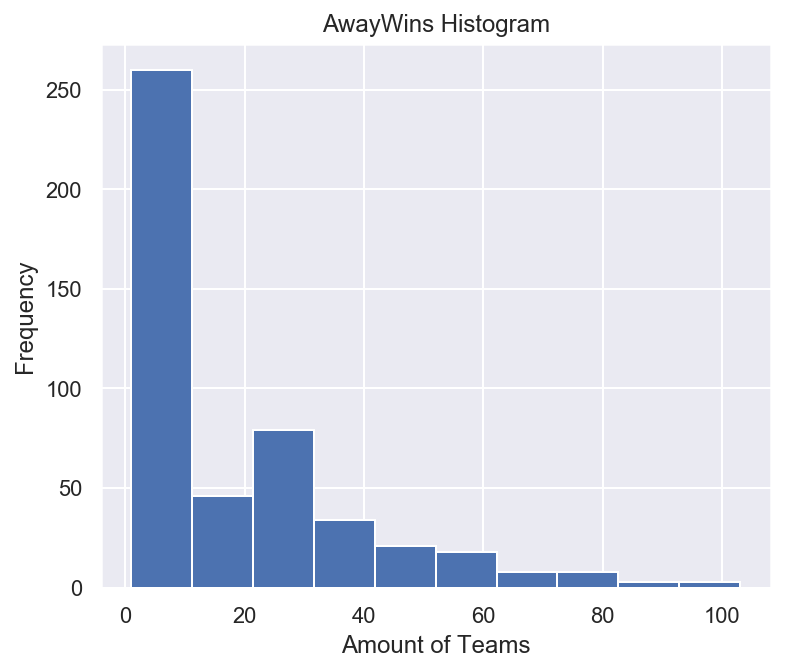

In [348]:
plt.hist(CombinedHomeandAway['Away_Wins'])
plt.title("AwayWins Histogram")
plt.xlabel("Amount of Teams")
plt.ylabel("Frequency")



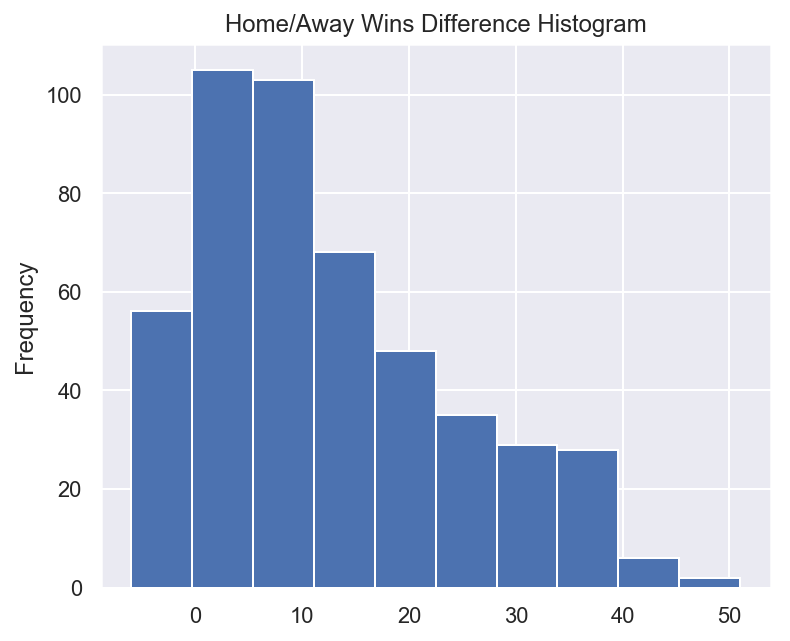

In [349]:
CombinedHomeandAway['Difference_of_Wins'].plot(kind='hist', title= 'Home/Away Wins Difference Histogram')
#Histogram clearly shows that almost 60 teams had more away wins than home wins, while the rest all have more Home Wins



In [350]:
skewness= stats.skew(CombinedHomeandAway['Difference_of_Wins'])
kurtosis= stats.kurtosis(CombinedHomeandAway['Difference_of_Wins'])
skewness,kurtosis
#Positvely Higly skewed to the right, where our mean and median are greater than the mode. 
#Very low kurtosis, platykurtic distribution where our peak is lower and Broader than a Normal Distribution (fatter right-side tail).


(0.7101724108662442, -0.26541509539018815)

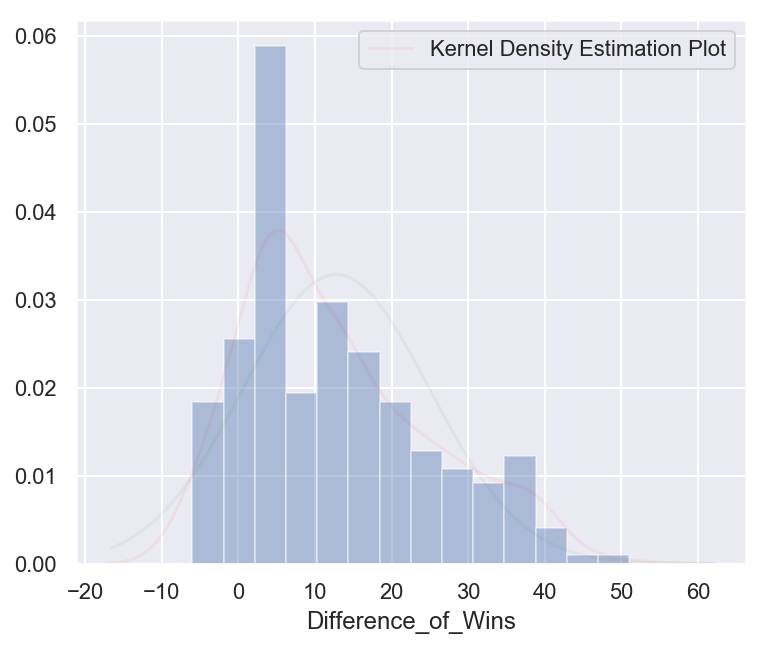

In [351]:
sns.distplot(CombinedHomeandAway['Difference_of_Wins'],
hist = True,kde = True, kde_kws={"color":"red","alpha":0.05,"label":"Kernel Density Estimation Plot"},
fit = stats.norm, fit_kws={"color":"green","alpha":0.05,"label":"Parametric fit"})
            

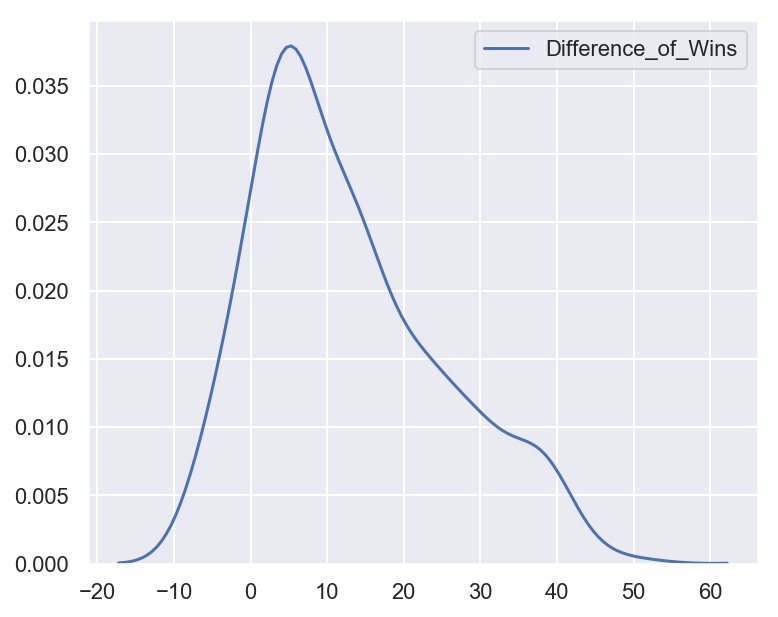

In [352]:
sns.kdeplot(CombinedHomeandAway['Difference_of_Wins'])
#KDE to show the % frequency of the amount of 

In [353]:
ttest_rel(CombinedHomeandAway['Home_Wins'],CombinedHomeandAway['Away_Wins'])
#Repeated T-Test to account for using the same team twice for home and away. Measuring the average home and away wins, and 
#Checking whether they differ significantly across their games. Our very small pvalue and large T-stat shows that our 
#Null hypothesis (Home and away wins have no statistical difference in averages) is False and can be rejected. 

Ttest_relResult(statistic=22.98522690915607, pvalue=2.4129466452683866e-79)